<a href="https://colab.research.google.com/github/ljzier/ST-554-repo/blob/main/Task3/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Linda Zier**

**ST 554: Big Data**

**Project 1**

# **Cross-Validation Algorithm for Linear Regression Models in a Time Series Setting**

This project utilizes the air quality data set available at the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/360/air+quality). This data is time series data (data recorded over time) for air quality measurements of pollutants in an Italian city. The dataset consists of 9,358 hourly-averaged observations collected from five metal oxide chemical sensors integrated into an air quality multisensor device. The device was deployed at road level in a heavily polluted urban area in Italy, and data were gathered over a one-year period from March 2004 through February 2005 (De Vito, 2008).

The pollutants measured, which are "true" (gold standard) measurements, are the following:

- **CO(GT) (CO concentration)**
- **C6H6(GT) (Benzene concentration)**
- NMHC(GT) (Non Metanic HydroCarbon concentration)
- NOx(GT) (NOx concentration)
- NO2(GT) (NO2 concentration)

It also contains weather related measurements.

- **T (temperature)**
- **RH (Relative humidity)**
- **AH (Absolute Humidity)**

The bottom three pollutants and other sensor measurements will not be used in this modeling.


Our goal is to determine the best model for predicting benzene concentrations with the given data.
This task involves coding up a cross-validation algorithm to evaluate SLR and MLR models in the
time series setting. Specifically, we want to see how well these models do at predicting benzene concentration by using a subset of the data to train the model and measure how well it predicts the next day. The model that produces the smaller Mean Squared Error (MSE) is the model that will win.

We will be looking at two competing models:
1. An SLR model that models the linear relationship between CO(GT) (Carbon Monoxide) as the predictor and C6H6(GT) (Benzene concentration) as the response.
2. AN MLR model that also uses CO(GT) (Carbon Monoxide) but includes weather data: T(temperature), RH (Relative humidity), and AH (Absolute Humidity) as the predictors for C6H6(GT) (Benzene concentration).

---



## Reading in the Data and Inspecting it

Our first step was to get the data from the UCI Machine Learning Repository. We inspected it and looked at summary information.

In [2]:
# Install the ucimlrepo package available at the UC Irvine Repository
!pip install ucimlrepo

# Import modules
import ucimlrepo as uci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Fetching the data from the UCI repository
air_quality = uci.fetch_ucirepo(id=360)

# Inspect data and get info on data types
air_quality = air_quality.data.features
air_quality.head()
air_quality.info()
air_quality.describe()
air_quality.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


## Data Cleaning

Our next step was to remove any observations where the C6H6(GT), CO(GT), T, RH, or AH are -200 as these represent missing
values.

In [3]:
# Get a sum for how many missing values
print((air_quality[["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]] == -200).sum())

# Create a copy to avoid modifying the original 'air_quality' directly
air_quality_temp = air_quality.copy()

# Replace -200 with NaN in the relevant columns
cols_to_clean = ["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]
air_quality_temp[cols_to_clean] = air_quality_temp[cols_to_clean].replace(-200, np.nan)

# Drop rows where any of the specified columns have NaN values
air_quality_clean = air_quality_temp.dropna(subset=cols_to_clean).copy()
air_quality_clean.info()


C6H6(GT)     366
CO(GT)      1683
T            366
RH           366
AH           366
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7344 non-null   object 
 1   Time           7344 non-null   object 
 2   CO(GT)         7344 non-null   float64
 3   PT08.S1(CO)    7344 non-null   int64  
 4   NMHC(GT)       7344 non-null   int64  
 5   C6H6(GT)       7344 non-null   float64
 6   PT08.S2(NMHC)  7344 non-null   int64  
 7   NOx(GT)        7344 non-null   int64  
 8   PT08.S3(NOx)   7344 non-null   int64  
 9   NO2(GT)        7344 non-null   int64  
 10  PT08.S4(NO2)   7344 non-null   int64  
 11  PT08.S5(O3)    7344 non-null   int64  
 12  T              7344 non-null   float64
 13  RH             7344 non-null   float64
 14  AH             7344 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage

We created a new version of the data with the five variables: C6H6(GT), CO(GT), T, RH, or AH, along with the Date variable. The values of the five variables were averaged across the given Date. A new variable "Day" was also created for ease of manipulation in our model section.

In [31]:
# Removing any columns that aren't "Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"
air_quality_clean = air_quality_clean[["Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"]]

# converting the date from an object to a date
air_quality_clean["Date"] = pd.to_datetime(air_quality_clean["Date"])

# Averaging the variables by date
air_data = air_quality_clean.groupby("Date").mean()

# Creating a day variable
air_data["Day"] = range(1, len(air_data)+1)
print(air_data)
air_data.info()

             C6H6(GT)    CO(GT)          T         RH        AH  Day
Date                                                                
2004-03-10   8.450000  1.966667  12.033333  54.900000  0.765633    1
2004-03-11   8.269565  2.239130   9.826087  64.230435  0.777039    2
2004-03-12  12.177273  2.804545  11.618182  50.190909  0.665164    3
2004-03-13  11.121739  2.695652  13.121739  50.682609  0.733013    4
2004-03-14   9.830435  2.469565  16.182609  48.317391  0.849209    5
...               ...       ...        ...        ...       ...  ...
2005-03-31   5.220833  1.387500  17.550000  50.083333  0.951917  343
2005-04-01   3.526087  1.108696  16.026087  35.404348  0.631135  344
2005-04-02   2.529167  0.854167  15.483333  32.225000  0.546167  345
2005-04-03   4.316667  1.141667  18.383333  33.695833  0.617583  346
2005-04-04   8.985714  2.078571  17.328571  41.842857  0.721250  347

[347 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2004-03-10 to

## Exploratory Model Fitting
We are considering two models:

- The first is an SLR model using CO(GT) to predict C6H6(GT).
- The second is an MLR model using CO(GT), T, RH, and AH to predict C6H6(GT). Essentially it considers the atmospheric effects in addition to CO levels.

Below I have plotted a scatterplot of CO(GT) vs. C6H6(GT) along with the simple linear regression (SLR) line of best fit. The algorithm has produced coefficients for intercept and slope.

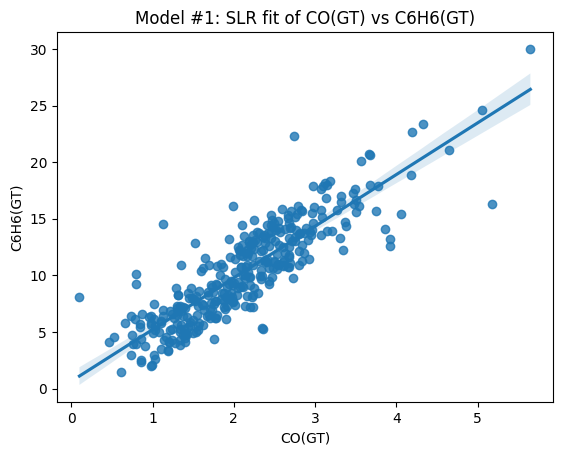

The intercept is  0.644770948344199
The coefficient is  [4.56536116]


In [32]:
# Model #1: SLR of x=CO(GT) vs. y=C6H6(GT).

# reshaping x valley into a column instead of a 1 dimensional array
# print(air_data[["CO(GT)"]].shape)
# print(air_data["CO(GT)"].values.reshape(-1,1).shape)

# Plotting CO(GT) vs C6H6(GT)
sns.regplot(x=air_data["CO(GT)"],y=air_data["C6H6(GT)"])
plt.xlabel("CO(GT)")
plt.ylabel("C6H6(GT)")
plt.title("Model #1: SLR fit of CO(GT) vs C6H6(GT)")
plt.show()

# using the Linear model function from sklearn module to fit the SLR
# creating a regression object
air_slr = linear_model.LinearRegression()
air_slr.fit(
    air_data[["CO(GT)"]], #this is a data frame because of the [[ ]]
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_slr.intercept_)
print( "The coefficient is ", air_slr.coef_)


The second model is an MLR model using CO(GT), T, RH, and AH to predict C6H6(GT). Here we have fit the model of CO(GT), T, RH, and AH to predict C6H6(GT).  Obviously this 5-dimensional cannot be plotted on a simple scatter plot, but the algorithm has produced coefficients for intercept and each of the "slopes" associated with the predictors.  

Now we look to the cross-validation step to decide which of these is better a predicting benzene concentration.



In [33]:
# MLR: Using using CO(GT), T, RH, and AH to predict C6H6(GT)

# using the Linear model function from sklearn module to fit the MLR
air_mlr = linear_model.LinearRegression()
air_mlr.fit(
    air_data[["CO(GT)", "T", "RH", "AH"]],
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_mlr.intercept_)
print( "The coefficients are ", air_mlr.coef_)

The intercept is  -1.8377694729981364
The coefficients are  [ 4.77080433  0.11973259 -0.01620259  0.68866811]


## Cross Validation ##

Our goal is to compare how well the two competing models perform in predicting benzene concentrations. Because the data are recorded over time (by Day/Date), we cannot use standard cross-validation methods that randomly split the data. Random splitting would ignore the temporal ordering and the likely correlation between nearby days.

Instead, we use a rolling approach: we use the first 250 days as the training set to predict the next day.  We calculate the Mean Square Error (MSE) between predicted and observed(actual).

Then we use the first 251 days as the training set and calculate the 252nd day and calculate that MSE, etc.  We sum all the squared errors to obtain the overall squared error for the cross-validation model and then take the average:  

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_{\text{observed}} - y_{\text{predicted}})^2
$$


This is done for the SLR model and the MLR model. In this way we can compare them to pick the model with the lower average MSE.

In [57]:
# Initial Cross-validation for SLR and MLR model comparison.
# The starting day is 250

# Define our X and y
X_mlr = ["CO(GT)", "T", "RH", "AH"]
X_slr = ["CO(GT)"]
y_col = "C6H6(GT)"

# starting training size value
train_st = 250

#initializing result dataframe
model_comp = []

# using a for loop to iterate through the process of increasing the training size
# and predicting until the end of the data is reached

for day in range(train_st, len(air_data)):

    # training set up to but not including test day
    X_train_mlr = air_data.iloc[:day][X_mlr]
    X_train_slr = air_data.iloc[:day][X_slr]
    y_train = air_data.iloc[:day][y_col]

    # the next day
    X_test_mlr = air_data.iloc[day:day+1][X_mlr]
    X_test_slr = air_data.iloc[day:day+1][X_slr]
    y_test = air_data.iloc[day:day+1][y_col]

    #fit the models
    slr_fit = linear_model.LinearRegression().fit(X_train_slr, y_train)
    mlr_fit = linear_model.LinearRegression().fit(X_train_mlr, y_train)

    #predict the next value
    slr_pred = slr_fit.predict(X_test_slr)
    mlr_pred = mlr_fit.predict(X_test_mlr)

    #calculate MSE
    mse_slr = mean_squared_error(y_test, slr_pred)
    mse_mlr = mean_squared_error(y_test, mlr_pred)

    model_comp.append([
        day + 1,             # actual day number
        day,                 # train size
        mse_slr, mse_mlr])   # mse's


# Convert the list of results to a dataframe
df_results = pd.DataFrame(model_comp, columns=['day', 'train_size', 'mse_slr', 'mse_mlr'])

# Print the dataframe with individual MSEs. In this case the MSE is the same as
# the squared error because they are all for a single day.
print(df_results)

#calculate the total mse for the MLR and SLR models
overall_mse_slr = df_results['mse_slr'].mean()
overall_mse_mlr = df_results['mse_mlr'].mean()

print(f"THE MSE for the SLR model is ", overall_mse_slr)
print(f"THE MSE for the MLR model is ", overall_mse_mlr)

    day  train_size    mse_slr    mse_mlr
0   251         250  10.669616   1.632153
1   252         251  22.555731   9.899428
2   253         252  79.916651  61.127787
3   254         253  34.133677  21.965161
4   255         254   8.167241   0.769942
..  ...         ...        ...        ...
92  343         342   3.268224   2.403935
93  344         343   4.962906   3.108343
94  345         344   4.206294   2.134818
95  346         345   2.416153   1.964801
96  347         346   1.326674   0.987894

[97 rows x 4 columns]
THE MSE for the SLR model is  7.402897202768712
THE MSE for the MLR model is  5.096311564583978


### Generalizing Cross Validation

Here we wrote a function to generalize the above.  It allows us to take in a particular X, and y, and allows the user to select the starting day. In this way, it could theoretically be used for another data set.

It returns the MSE.


In [55]:
# Generalized cross validation function
# defining a function to do this calculation on a given X, y and starting day

# function to get the MSE for 1 day
def get_mse(X_df, y_response, test_index):
   """
   This function takes in a data frame of predictors X and a 1D response y as well
   as a starting day which will be correspond to the last day in the training data.
   It will return the MSE.
   """
   # creating the train and test datasets
   X_train = X_df.iloc[:test_index] #this works sinceX_df starts with index 0
   y_train= y_response.iloc[:test_index]

   X_test = X_df.iloc[test_index:test_index+1]
   y_test = y_response.iloc[test_index:test_index+1]

   # fit the model to the training set
   model_fit = linear_model.LinearRegression().fit(X_train, y_train)

   #predict the next value using the test set
   y_pred = model_fit.predict(X_test)

   #calculate the MSE
   model_mse = mean_squared_error(y_test, y_pred)

   #return the MSE
   return model_mse


 Next we wrote a function to obtain the CV value over all the days (other than the initial training block).  The above function is called within this function and then incremented through the days returning the total MSE.

In [69]:
# function to obtain our CV value over all the days AFTER the initial day

def get_CV_value(X_df, y_response, initial_train_sz):
    """
    This function will obtain our MSE values for our 1-step ahead predictions
    """
    #initializing the mse
    total_mse=0

    # by range and going to len(X_df) I'm stopping before the last day
    # appending to total_mse as I go
    for i in range(initial_train_sz, len(X_df)):
        total_mse += get_mse(X_df, y_response, i)
    #calculate MSE
    ave_mse = total_mse / (len(X_df) - initial_train_sz)

    return ave_mse

Finally, we ran the function using both the SLR model and the MLR model. It allows the user to enter the starting day (initial training size) and then uses the rolling approach described earlier to calculate our CV MSE.


In [81]:
# Running our function on the SLR model and our MLR model

# Define our X and y using the original data set
X_mlr = air_data[["CO(GT)", "T", "RH", "AH"]]
X_slr = air_data[["CO(GT)"]]
y_response = air_data["C6H6(GT)"]


# Input validation loop
while True:
    try:
        # Prompting the user for day value for initial training size
        print(f"Enter the initial training size. For this data set this needs to be between (1 and {len(air_data) - 1}): ")
        day = int(input())
        if (1 <= day < (len(air_data))):
            break # Valid value
        else:
            print(f"Try again in the proper range. Please enter a day value between 1 and {len(air_data) - 1}.")
    except ValueError:
            print(f"That's not an integer!!! ")


#Getting the CV value for the SLR function
slr_cv = get_CV_value(X_slr, y_response, day)

# Getting the CV value for the MLR function
mlr_cv = get_CV_value(X_mlr, y_response, day)

print("The CV MSE value for the SLR model is: ", slr_cv)
print("The CV MSE value for the MLR model is: ", mlr_cv)

Enter the initial training size. For this data set this needs to be between (1 and 346): 
iogh
That's not an integer!!! 
Enter the initial training size. For this data set this needs to be between (1 and 346): 
34
The CV MSE value for the SLR model is:  5.3320581324422704
The CV MSE value for the MLR model is:  3.7242940612097595


The MLR model performed much better than the SLR model since it has a lower cross validation MSE. This demonstrates better predictive performance so we fit this as our chosen model.

In [89]:
# MLR: Using using CO(GT), T, RH, and AH to predict C6H6(GT)

# using the Linear model function from sklearn module to fit the MLR
air_mlr = linear_model.LinearRegression()
air_mlr.fit(
    air_data[["CO(GT)", "T", "RH", "AH"]],
    air_data["C6H6(GT)"]
)

print("Intercept:", air_mlr.intercept_)

# print the "slopes" for each
for i in range(len(X_mlr.columns)):
    print("The slope for", X_mlr.columns[i], "is:", air_mlr.coef_[i])

Intercept: -1.8377694729981364
The slope for CO(GT) is: 4.77080432907099
The slope for T is: 0.11973258636982986
The slope for RH is: -0.016202586785609818
The slope for AH is: 0.688668112749305


The final model with intercept and slope coefficients is shown below.  

$$
C6H6(GT) = \beta_0 + \beta_1 \, CO(GT) + \beta_2 \, T + \beta_3 \, RH + \beta_4 \, AH + \varepsilon
$$

The estimated coefficients are:

$$
\begin{aligned}
\beta_0 &= -1.8378 \\
\beta_1 &=  4.7708 \\
\beta_2 &=  0.1197 \\
\beta_3 &= -0.0162 \\
\beta_4 &= 0.6887 \\
\end{aligned}
$$







## References

Vito, S. (2008). Air Quality Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.
